In [1]:
using PyPlot, Interact

addprocs(6);

@everywhere push!(LOAD_PATH, "../src/")

@everywhere using HDStat

INFO: Loading help data...


### Generative model

Our model for low-dimensional linear encoding of stimulus,
$$
R^F = UX^0 + Z
$$

where
  - $R^F$, the $N$-by-$P$, firing-rate matrix of the entire population of neurons,
  - $X^0$, the $K$-by-$P$ signal, or stimulus, matrix that is sampled from a $K$-dimensional subspace with i.i.d. elements from $\mathcal{N}(0, \frac{N}{K}\sigma_s^2)$,
  - $U$, the $N$-by-$K$ orthogonal embedding matrix of the stimulus subspace,
  - $Z$, the $N$-by-$P$ activities noise with $Z_{ij} \sim \mathcal{N}(0, \sigma_n^2)$.
  
The generative model's parameters are $(N, K, P, \sigma_s, \sigma_n)$, we will use 

$$X = UX^0$$

to denote the embedded signal/stimulus. Note that for **individual neurons** and the **population** as a whole, we have the signal-to-noise ratio

$$
\text{SNR} = \frac{\sigma_s^2}{\sigma_n^2}
$$

and for the **signal subspace** spanned by columns of $U$, we have the subspace signal-to-noise ratio

$$
\text{SNR}_s = \frac{N}{K}\frac{\sigma_s^2}{\sigma_n^2} = \frac{N}{K}SNR
$$

We will use $k$, $m$, and $p$ to denote the normalized quantities $K / N$, $M / N$, and $P / N$.
  
### Observation model
We model the observations of neural activities as
$$
R^S = SR^F = S(X + Z)
$$
where $S$ is a $M$-by-$N$ random sampling matrix. Additionally, we also measure the behavior output $y$.

The observation model's parameter is simply $M$.

## Problem 1: Inferring $K$

The inferred $K$ from the data is the number of $\hat{X}$'s singular values above the output noise floor

$$
\sigma_n\left(\sqrt{P} + \sqrt{M}\right)
$$

This, in turn, correspond to the number of $SUX^0$'s singular values that are above the input-referred noise floor. The dimensionality of the stimulus space, $K$, is, then, correctly inferred given the **sufficient** condition,

$$
\sigma_n\left(MP\right)^{1/4} \leq \sigma_-(SU)\sigma_-(X^0) \leq \sigma_-(SUX^0)
$$

with $\sigma_-$ denoting the minimum non-zero singular value. Given that

$$
\sigma_-(X^0) = \sigma_s\left( \sqrt{P} - \sqrt{K} \right),
\sigma_-(SU) = \sqrt{m(1 - k)} - \sqrt{k(1 - m)}
$$

we have the **sufficient** condition as,

$$
\left(1 - \sqrt{\frac{K}{P}} \right)^2\sqrt{MP}\frac{\sigma_s^2}{\sigma_n^2}\left( \sqrt{\frac{1}{K} - \frac{1}{N}} - \sqrt{\frac{1}{M} - \frac{1}{N}} \right)^2 \geq 1
$$

In [2]:
@everywhere function inferK(model::ObsModel; Rs = None)
    if Rs == None; Rs = randfull(model)[:Rs]; end
    let noise = model.noise
        _, S, _ = svd(Rs)
        return sum(S .> noise.sigma * (sqrt(noise.p) + sqrt(model.m)))
    end
end

### Inferring dimensionality correctly, checking against theory

In [3]:
# @everywhere K, N, σs, σn = 2, 5000, 0.09, 1
# @everywhere Ms, Ps = 40:10:500, 40:10:500
@everywhere K, N, σs, σn = 20, 5000, 0.8, 1.0
@everywhere Ms, Ps = 40:20:500, 40:20:500

rst = [@spawn inferK(ObsModel(M, LowDModel(K, N, P, σs * sqrt(N / K)), MPModel(N, P, σn))) for M in Ms, P in Ps]
dims = map(fetch, rst);

In [13]:
theory1 = ((sqrt(1 / K - 1 / N) - sqrt(1 ./ Ms - 1 / N)).^2 .* sqrt(Ms)) * ((1 - sqrt(K ./ Ps')).^2 .* sqrt(Ps')) * σs^2 / σn^2 .> 1;
theory2 = sqrt(Ms * Ps') / K * σs^2 / σn^2 .> 1
theory3 = (-sqrt(Ms) .+ sqrt((Ms .* Ps') / K)).^2 .> σn^2 / σs^2 * sqrt(Ms .* Ps')

24x24 BitArray{2}:
 false  false  false  false  false  …  true  true  true  true  true  true
 false  false  false  false  false     true  true  true  true  true  true
 false  false  false  false   true     true  true  true  true  true  true
 false  false  false  false   true     true  true  true  true  true  true
 false  false  false   true   true     true  true  true  true  true  true
 false  false  false   true   true  …  true  true  true  true  true  true
 false  false  false   true   true     true  true  true  true  true  true
 false  false  false   true   true     true  true  true  true  true  true
 false  false   true   true   true     true  true  true  true  true  true
 false  false   true   true   true     true  true  true  true  true  true
 false  false   true   true   true  …  true  true  true  true  true  true
 false  false   true   true   true     true  true  true  true  true  true
 false  false   true   true   true     true  true  true  true  true  true
 false  false   tru

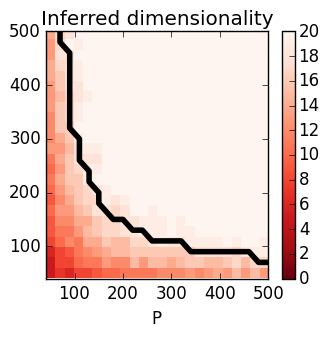

In [17]:
figure(figsize=(3.5, 3.5))
imshow(dims, vmin=0, aspect="auto", interpolation="nearest", origin="lower", cmap="Reds_r", extent=[minimum(Ps), maximum(Ps), minimum(Ms), maximum(Ms)]);
colorbar();
contour(repmat(Ps', length(Ms), 1), repmat(Ms, 1, length(Ps)), theory1, 1, linewidths=4, colors="k")
xlabel("P");
# contour(repmat(Ps', length(Ms), 1), repmat(Ms, 1, length(Ps)), theory1, 1, linewidths=4, colors="r")

title("Inferred dimensionality")
tight_layout()
savefig("../figures/static.dim.eps")

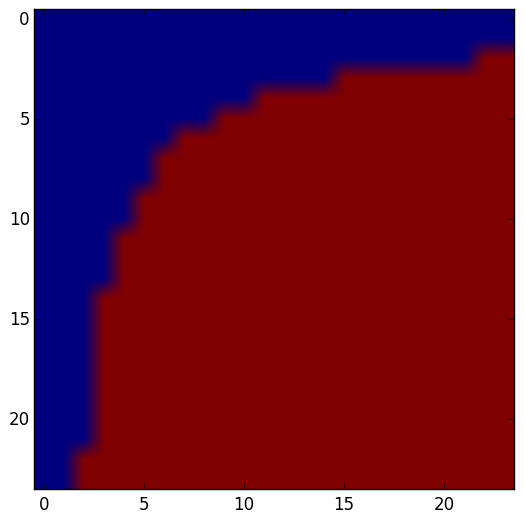

PyObject <matplotlib.image.AxesImage object at 0x7f4442f609e8>

In [12]:
imshow(theory1)

## Problem 2: Decoding the Stimulus

Given $R^S$ and $X^0$, can we find decoding matrix $W$, $K$-by-$M$, such that $|WR^S - X^0|_2$ is minimized in a validation dataset?

**Algorithm #0**: In the infinite data limit, we have

$$
W = \left< X^0{R^S}^T \right> \left< R^S{R^S}^T \right>^{-1} = U^TS^T \left( SUU^TS^T + \frac{1}{\text{SNR}_s}I \right)^{-1}
$$

which is the best possible decoder. Its performance, $R^2$, is

$$
\frac{k + (k + m)\text{SNR} - \sqrt{\left( \sigma_-(SU)^2\text{SNR} + k \right) \left( \sigma_+(SU)^2\text{SNR} + k \right)}}{2k(k+\text{SNR})}
$$

as shown in <a href="Analysis%20-%20Static%20Low-D%20Stim%20Decoding%2C%20Infinite%20Data%20Proof.ipynb">this notebook</a>

**Algorithm #1**: Simple linear regression of $X^0$ against $R^S$.

**Algorithm #2**: Infer the sampled signal subspace, $\hat{U}$, from $R^S$ first using low-rank perturbation theory, then regress $X^0$ against $\hat{U}^TR^S$

**Algorithm #3**: Recover the best sampled signal $\tilde{R}^S$ from $R^S$ first using Gavish and Donoho and the Frobenius error metric, regress $X^0$ against $\tilde{R}^S$.

In [180]:
# algorithm #0
@everywhere function best_W(model::ObsModel)
    A = model.S * model.sig.U
    u, s, v = svd(A)
    a = model.noise.sigma^2 / model.sig.sigma^2
    return v * diagm(s ./ (s.^2 + a)) * u'
end

# algorithm #1
@everywhere function simple_W(Rs, X0)
    U, S, V = svd(Rs)
    return (X0 * Rs') * U * diagm(S.^-2) * U'
#     return (Rs' \ X0')'
end

# algorithm #2
@everywhere function subspace_W(Rs, X0, model::ObsModel)
    let noise = model.noise, sig = model.sig
        U, S, V = svd(Rs)
        K = sum(S .> noise.sigma * (sqrt(noise.p) + sqrt(model.m)))
#         K = sig.k
        if K < 1; return zeros(sig.k, model.m); end;
        Rtilde = U[:, 1:K]' * Rs;
        return (Rtilde' \ X0')' * U[:, 1:K]'
#         return (X0 * Rtilde') * inv(Rtilde * Rtilde') * U[:, 1:K]'
    end
end

# algorithm #3
# using the non-linearity for minimizing the nuclear norm
@everywhere function signal_W(Rs, X0, model::ObsModel)
    let noise = model.noise, sig = model.sig
        U, S, V = svd(Rs)
        mask = S .> noise.sigma * (sqrt(noise.p) + sqrt(model.m))
        tmp = S[mask].^2 - noise.sigma^2 * (model.m + noise.p)
        S[mask] = sqrt(tmp + sqrt(tmp.^2 - 4 * model.m * noise.p * noise.sigma^4)) / sqrt(2)
#         S[mask] = sqrt(tmp.^2 - 4 * model.m * noise.p * noise.sigma^4) ./ S[mask]
        S[~mask] = 0
        Rstilde = U[:, mask]' * U * diagm(S) * V'
        return (Rstilde' \ X0')' * U[:, mask]'
#         return (X0 * Rstilde') * inv(Rstilde * Rstilde') * U[:, 1:K]'
    end
end

Options{:ToggleButtons,Int64}([Input{Int64}] 2000,"N",2000,"2000",["2000"=>2000,"5000"=>5000])

Options{:ToggleButtons,Int64}([Input{Int64}] 20,"M",20,"20",["20"=>20,"70"=>70,"120"=>120,"170"=>170,"220"=>220,"270"=>270,"320"=>320,"370"=>370,"420"=>420,"470"=>470,"520"=>520,"570"=>570,"620"=>620,"670"=>670,"720"=>720,"770"=>770,"820"=>820,"870"=>870,"920"=>920,"970"=>970])

Options{:ToggleButtons,Int64}([Input{Int64}] 5,"K",5,"5",["5"=>5,"10"=>10,"15"=>15,"20"=>20,"25"=>25,"30"=>30,"35"=>35,"40"=>40,"45"=>45,"50"=>50])

Options{:ToggleButtons,Int64}([Input{Int64}] 20,"P",20,"20",["20"=>20,"70"=>70,"120"=>120,"170"=>170,"220"=>220,"270"=>270,"320"=>320,"370"=>370,"420"=>420,"470"=>470,"520"=>520,"570"=>570,"620"=>620,"670"=>670,"720"=>720,"770"=>770,"820"=>820,"870"=>870,"920"=>920,"970"=>970])

Slider{Float64}([Input{Float64}] 0.5,"σs",0.5,0.1:0.1:1.0)

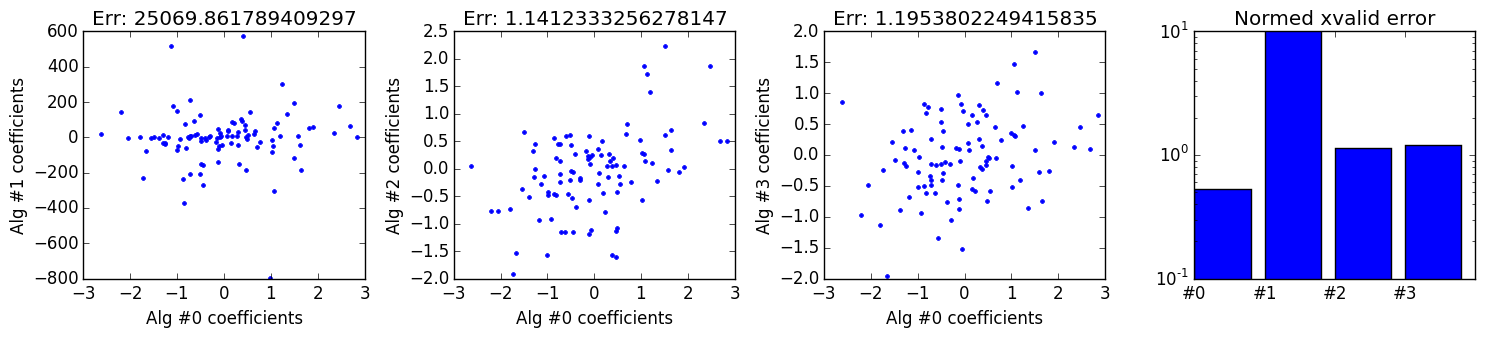

In [179]:
f = figure(figsize=(15, 3.5))
σn = 1

@manipulate for N in [2000, 5000], M in [20:50:1000], K in [5:5:50], P in [20:50:1000], σs in 0.1:0.1:1
    sig = LowDModel(K, N, P, σs * sqrt(N / K))
    noise = MPModel(N, P, σn)
    model = ObsModel(M, sig, noise)

    train = randfull(model)
        
    X0test = zeros(K, 0)
    Rstest = zeros(M, 0)
    while size(X0test, 2) < 10000
        tmp = randfull(model)
        X0test = [X0test tmp[:X0]]
        Rstest = [Rstest tmp[:Rs]]
    end
    
    W_best = best_W(model)
    W_simple = simple_W(train[:Rs], train[:X0])
    W_subspace = subspace_W(train[:Rs], train[:X0], model)
    W_signal = signal_W(train[:Rs], train[:X0], model)

    k, m = K / N, M / N
    lp, lm = (sqrt(k * (1 - m)) + sqrt(m * (1 - k)))^2, (sqrt(k * (1 - m)) - sqrt(m * (1 - k)))^2
    s = σs^2 / σn^2
    err_best = 1 - (k + (k + m) * s - sqrt((lm * s + k) * (lp * s + k))) / 2 / k / (k + s)
    err_simple = norm(W_simple * Rstest - X0test)^2 / norm(X0test)^2
    err_subspace = norm(W_subspace * Rstest - X0test)^2 / norm(X0test)^2
    err_signal = norm(W_signal * Rstest - X0test)^2 / norm(X0test)^2
    
    withfig(f) do
        subplot(141)
        plot(vec(W_best), vec(W_simple), ".")
        ylabel("Alg #1 coefficients"); xlabel("Alg #0 coefficients"); title(string("Err: ", err_simple))
        subplot(142)
        plot(vec(W_best), vec(W_subspace), ".")
        ylabel("Alg #2 coefficients"); xlabel("Alg #0 coefficients"); title(string("Err: ", err_subspace))
        subplot(143)
        plot(vec(W_best), vec(W_signal), ".")
        ylabel("Alg #3 coefficients"); xlabel("Alg #0 coefficients"); title(string("Err: ", err_signal))
        subplot(144)
        bar(1:4, [err_best, err_simple, err_subspace, err_signal])
        xticks(1:4, ["#0", "#1", "#2", "#3"]); title("Normed xvalid error")
        ylim([1e-1, 1e1]); yscale("log")
        tight_layout()
    end    
end

### Now lets explore some 2-dimensional parameters space $M$ and $P$ with fixed $K$, $N$, $\sigma_s$, $\sigma_n$

In [150]:
@everywhere function trial(K, N, M, P, σs, σn)
    sig = LowDModel(K, N, P, σs * sqrt(N / K))
    noise = MPModel(N, P, σn)
    model = ObsModel(M, sig, noise)
    
    train = randfull(model)
        
    X0test = zeros(K, 0)
    Rstest = zeros(M, 0)
    while size(X0test, 2) < 2000
        tmp = randfull(model)
        X0test = [X0test tmp[:X0]]
        Rstest = [Rstest tmp[:Rs]]
    end
    
    W_best = best_W(model)
    W_simple = simple_W(train[:Rs], train[:X0])
    W_subspace = subspace_W(train[:Rs], train[:X0], model)
    W_signal = signal_W(train[:Rs], train[:X0], model)

    k, m = K / N, M / N
    lp, lm = (sqrt(k * (1 - m)) + sqrt(m * (1 - k)))^2, (sqrt(k * (1 - m)) - sqrt(m * (1 - k)))^2
    s = σs^2 / σn^2
    err_best = 1 - (k + (k + m) * s - sqrt((lm * s + k) * (lp * s + k))) / 2 / k / (k + s)
    err_simple = norm(W_simple * Rstest - X0test)^2 / norm(X0test)^2
    err_subspace = norm(W_subspace * Rstest - X0test)^2 / norm(X0test)^2
    err_signal = norm(W_signal * Rstest - X0test)^2 / norm(X0test)^2
    
    return (err_best, err_simple, err_subspace, err_signal)
end

In [186]:
@everywhere K, N, σs, σn = 20, 5000, 0.8, 1.0
@everywhere Ms, Ps = 40:10:500, 40:10:500

In [187]:
rst = [@spawn trial(K, N, M, P, σs, σn) for M = Ms, P = Ps];
rst = map(fetch, rst);

In [188]:
err_best = map(x -> x[1], rst);
err_simple = map(x -> x[2], rst);
err_subspace = map(x -> x[3], rst);
err_signal = map(x -> x[4], rst);

In [189]:
valid = ((sqrt(1 / K - 1 / N) - sqrt(1 ./ Ms - 1 / N)).^2 .* sqrt(Ms)) * ((1 - sqrt(K ./ Ps')).^2 .* sqrt(Ps')) * σs^2 / σn^2 .> 1;

### Numerical experiments on normalized err in the M-P plane

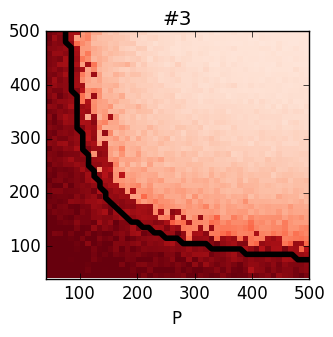

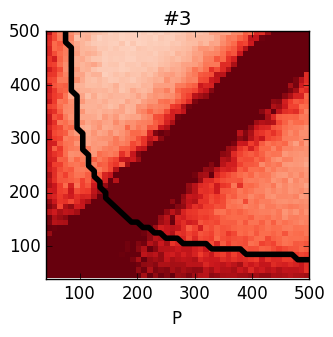

In [190]:
function plot_helper(err)
    extent = [minimum(Ps), maximum(Ps), minimum(Ms), maximum(Ms)]
    imshow(err, aspect="auto", interpolation="nearest", origin="lower", cmap="Reds", vmin=0, vmax=1, extent=extent);
#     colorbar();
    contour(repmat(Ps', length(Ms), 1), repmat(Ms, 1, length(Ps)), valid, 1, linewidths=4, colors="k")
end

# figure(figsize=(15, 3.5))
# subplot(141)
# plot_helper(err_best)
# title("#0"); ylabel("M"); xlabel("P")
# subplot(142)
# plot_helper(err_simple)
# title("#1"); xlabel("P")
# subplot(143)
# plot_helper(err_subspace)
# title("#2"); xlabel("P")
# subplot(144)
# plot_helper(err_signal)
# title("#3"); xlabel("P")
# tight_layout()

figure(figsize=(3.5, 3.5))

plot_helper(err_subspace)
title("#3"); xlabel("P")
tight_layout()
savefig("../figures/static.err.rec.eps")

figure(figsize=(3.5, 3.5))

plot_helper(err_simple)
title("#3"); xlabel("P")
tight_layout()
savefig("../figures/static.err.simple.eps")

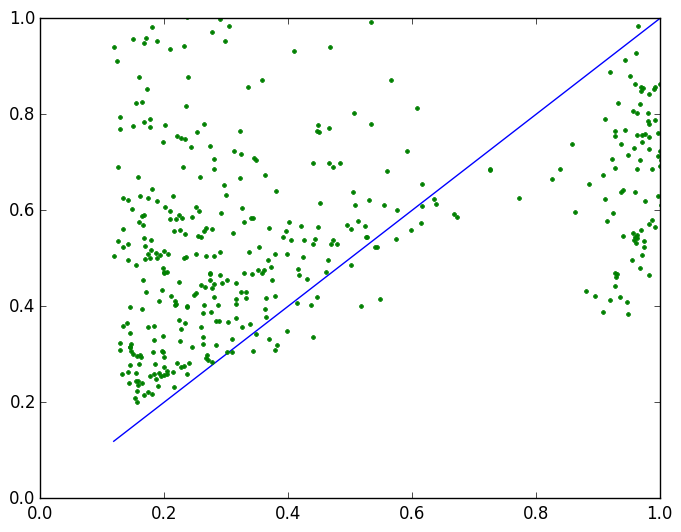

(0,1)

In [170]:
plot(sort(err_signal[:]), sort(err_signal[:]))
plot(err_signal[:], err_simple[:], ".")
xlim([0, 1]); ylim([0, 1])